In [1]:
import numpy as np

from matplotlib import pyplot as plt

In [2]:
klin, plin = np.loadtxt('templates/desi_pk.txt', unpack=True)
klin, pnw = np.loadtxt('templates/desi_pnw.txt', unpack=True)

pw = plin - pnw

(0.0, 0.3)

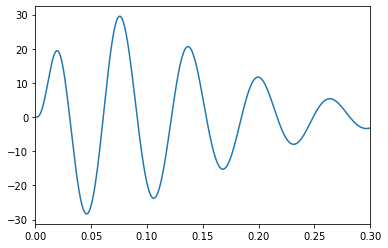

In [3]:
plt.plot(klin, klin * (plin - pnw))
plt.xlim(0,0.3)

In [4]:
# Compute Dampings in Zeldovich
import sys
sys.path.append('./lss_likelihood/')

from linear_theory import*
from scipy.special import spherical_jn
from scipy.integrate import simps


In [5]:
zfid = 0.8
OmM_fid = 0.3
Rsmooth = 10
rsdrag_fid = 100

Dz   = D_of_a(1/(1.+zfid), OmegaM=OmM_fid)
fz   = f_of_a(1/(1.+zfid), OmegaM=OmM_fid)

Sk = np.exp(-0.5*(klin*Rsmooth)**2)
j0 = spherical_jn(0,klin*rsdrag_fid)        

sigmadd = Dz**2 * simps( 2./3 * plin * (1-Sk)**2 * (1-j0), x = klin) / (2*np.pi**2)
sigmass = Dz**2 * simps( 2./3 * plin * (-Sk)**2 * (1-j0),  x = klin) / (2*np.pi**2)

sigmads_dd = Dz**2 * simps( 2./3 * plin * (1-Sk)**2, x = klin) / (2*np.pi**2)
sigmads_ss = Dz**2 * simps( 2./3 * plin * (-Sk)**2, x = klin) / (2*np.pi**2)
sigmads_ds = -Dz**2 * simps(2./3 * plin * (1-Sk)*(-Sk)*j0, x = klin) / (2*np.pi**2)

In [6]:
sigmadd * (1 + fz)

13.740224505213163

In [7]:
(0.5*sigmads_dd+0.5*sigmads_ss+sigmads_ds)

12.393777762276182

In [8]:
(0.5*sigmads_dd+0.5*sigmads_ss+sigmads_ds)*(1+fz)

22.70041650810544

### Single $\mu$

In [9]:
mu = 1

B1 = 1
F = 0.8

f0 = 0.8
rsd_fac = 1 + f0*(2+f0)*mu**2

# Pdd
dampfac_dd = np.exp( -0.5 * klin**2 * (sigmadd * rsd_fac) )
pdd = ( (1 + F*mu**2)*(1-Sk) + B1 )**2 * dampfac_dd * pw

# then Pss
dampfac_ss = np.exp( -0.5 * klin**2 * sigmass * rsd_fac )
pss = Sk**2 * (1 + F*mu**2)**2 * dampfac_ss * pw
        
# Finally Pds
dampfac_ds = np.exp(-0.5 * klin**2 * (0.5*sigmads_dd+0.5*sigmads_ss+sigmads_ds) * rsd_fac )
linfac = - Sk * (1+F*mu**2) * ( (1+F*mu**2)*(1-Sk) + B1 )
pds = linfac * dampfac_ds * pw

ptrue = pdd + pss - 2*pds

(0.0, 0.3)

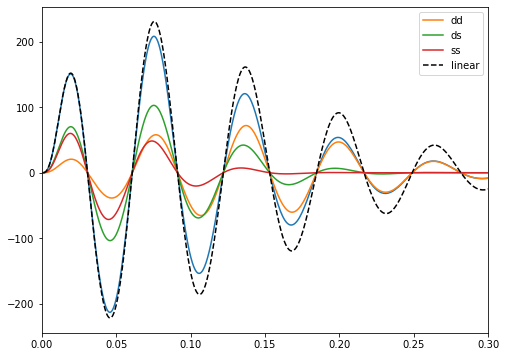

In [10]:
plt.figure(figsize=(8,6))

Sigma = 3

plt.plot(klin, klin * ptrue)

plt.plot(klin, klin * pdd, label='dd')
plt.plot(klin, -2*klin * pds, label='ds')
plt.plot(klin, klin * pss, label='ss')



#plt.plot(klin, klin * (1 + B1 + F*mu**2)**2 * pw * np.exp(-0.5 * klin**2 * Sigma**2))

plt.plot(klin, klin * (1 + B1 + F*mu**2)**2 * pw, 'k--', label='linear')

plt.legend()

plt.xlim(0,0.3)

(0.0, 0.3)

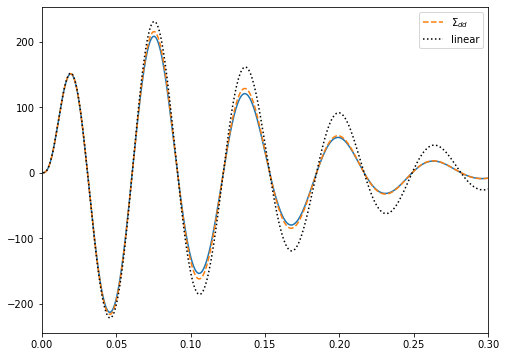

In [11]:
plt.figure(figsize=(8,6))

plt.plot(klin, klin * ptrue)

plt.plot(klin, klin * (1 + B1 + F*mu**2)**2 * pw * np.exp(-0.5 * klin**2 * sigmadd * rsd_fac), '--', label=r'$\Sigma_{dd}$')

plt.plot(klin, klin * (1 + B1 + F*mu**2)**2 * pw, 'k:', label='linear')

plt.legend()

plt.xlim(0,0.3)

### Redshift Space Multipoles

In [12]:
ngauss = 4
nus, ws = np.polynomial.legendre.leggauss(2*ngauss)
nus_calc = nus[0:ngauss]
        
L0 = np.polynomial.legendre.Legendre((1))(nus)
L2 = np.polynomial.legendre.Legendre((0,0,1))(nus)
L4 = np.polynomial.legendre.Legendre((0,0,0,0,1))(nus)

In [16]:
def compute_bao_pkmu(mu, mode='Zel',sigma_emp = sigmadd):
    rsd_fac = 1 + f0*(2+f0)*mu**2
    if mode == 'Zel':
        # Pdd
        dampfac_dd = np.exp( -0.5 * klin**2 * (sigmadd * rsd_fac) )
        pdd = ( (1 + F*mu**2)*(1-Sk) + B1 )**2 * dampfac_dd * pw
    
        # then Pss
        dampfac_ss = np.exp( -0.5 * klin**2 * sigmass * rsd_fac )
        pss = Sk**2 * (1 + F*mu**2)**2 * dampfac_ss * pw
        
        # Finally Pds
        dampfac_ds = np.exp(-0.5 * klin**2 * (0.5*sigmads_dd+0.5*sigmads_ss+sigmads_ds) * rsd_fac )
        linfac = - Sk * (1+F*mu**2) * ( (1+F*mu**2)*(1-Sk) + B1 )
        pds = linfac * dampfac_ds * pw

        return pdd + pss - 2*pds
    
    elif mode == 'linear':
        return (1 + B1 + F*mu**2)**2 * pw
    
    elif mode == 'empirical':
        return (1 + B1 + F*mu**2)**2 * np.exp(-0.5 * klin**2 * rsd_fac * sigma_emp) * pw

In [17]:
pknutable = np.zeros((len(nus),len(klin)))
    
for ii, nu in enumerate(nus_calc):
    pknutable[ii,:] = compute_bao_pkmu(nu)

pknutable[ngauss:,:] = np.flip(pknutable[0:ngauss],axis=0)
        
p0_zel = 0.5 * np.sum((ws*L0)[:,None]*pknutable,axis=0)
p2_zel = 2.5 * np.sum((ws*L2)[:,None]*pknutable,axis=0)

In [18]:
pknutable = np.zeros((len(nus),len(klin)))
    
for ii, nu in enumerate(nus_calc):
    pknutable[ii,:] = compute_bao_pkmu(nu,mode='empirical')

pknutable[ngauss:,:] = np.flip(pknutable[0:ngauss],axis=0)
        
p0_emp = 0.5 * np.sum((ws*L0)[:,None]*pknutable,axis=0)
p2_emp = 2.5 * np.sum((ws*L2)[:,None]*pknutable,axis=0)

In [19]:
pknutable = np.zeros((len(nus),len(klin)))
    
for ii, nu in enumerate(nus_calc):
    pknutable[ii,:] = compute_bao_pkmu(nu,mode='empirical', sigma_emp=(0.5*sigmads_dd+0.5*sigmads_ss+sigmads_ds))
    
pknutable[ngauss:,:] = np.flip(pknutable[0:ngauss],axis=0)
        
p0_emp2 = 0.5 * np.sum((ws*L0)[:,None]*pknutable,axis=0)
p2_emp2 = 2.5 * np.sum((ws*L2)[:,None]*pknutable,axis=0)

In [20]:
pknutable = np.zeros((len(nus),len(klin)))
    
for ii, nu in enumerate(nus_calc):
    pknutable[ii,:] = compute_bao_pkmu(nu,mode='empirical', sigma_emp=sigmass)

pknutable[ngauss:,:] = np.flip(pknutable[0:ngauss],axis=0)
        
p0_emp3 = 0.5 * np.sum((ws*L0)[:,None]*pknutable,axis=0)
p2_emp3 = 2.5 * np.sum((ws*L2)[:,None]*pknutable,axis=0)

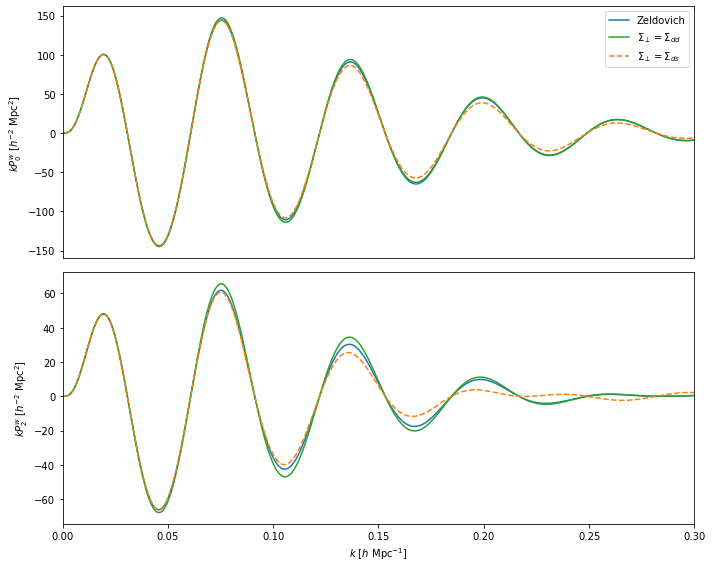

In [21]:
plt.figure(figsize=(10,8))

plt.subplot(2,1,1)

plt.plot(klin, klin * p0_zel, 'C0', label='Zeldovich')
plt.plot(klin, klin * p0_emp, 'C2', label=r'$\Sigma_\perp = \Sigma_{dd}$')
plt.plot(klin, klin * p0_emp2, 'C1--', label=r'$\Sigma_\perp = \Sigma_{ds}$')


plt.xticks([])
plt.xlim(0,0.3)

plt.ylabel(r'$k P^w_0$ [$h^{-2}$ Mpc$^2$]')

plt.legend()

plt.subplot(2,1,2)

plt.plot(klin, klin * p2_zel, 'C0')
plt.plot(klin, klin * p2_emp, 'C2')
plt.plot(klin, klin * p2_emp2, 'C1--')

plt.xlim(0,0.3)

plt.ylabel(r'$k P^w_2$ [$h^{-2}$ Mpc$^2$]')
plt.xlabel(r'$k$ [$h$ Mpc$^{-1}$]')

plt.tight_layout()



In [22]:
print(sigmadd, (0.5*sigmads_dd+0.5*sigmads_ss+sigmads_ds), sigmass)
print(sigmadd**0.5, (0.5*sigmads_dd+0.5*sigmads_ss+sigmads_ds)**0.5)

7.501769355667461 12.393777762276182 12.891824471308164
2.7389358071461736 3.520479763082893


### Compare to DESI error bars

In [23]:
pkells = np.loadtxt('data/pkells_recsym_mean_cubic.dat')
cov = np.loadtxt('data/pkells_recsym_cov_postrecon_cubic.txt')

In [24]:
kdats = pkells[:,0]
err0 = np.diag(cov)[:100]**0.5
err2 = np.diag(cov)[100:]**0.5

In [25]:
np.sqrt(7.5)

2.7386127875258306

(0.0, 0.3)

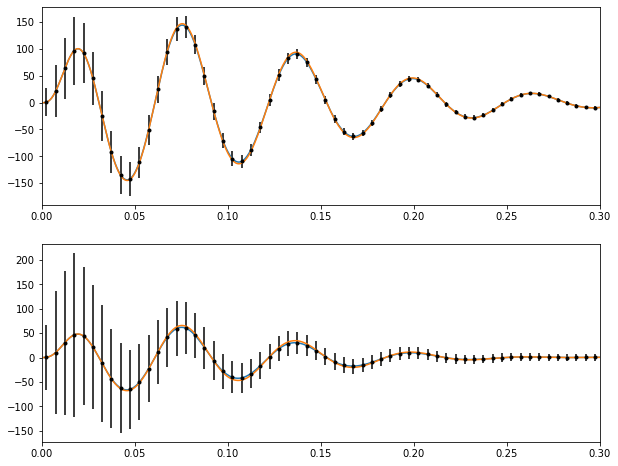

In [26]:
plt.figure(figsize=(10,8))

plt.subplot(2,1,1)

plt.plot(klin, klin * p0_zel, 'C0')
plt.plot(klin, klin * p0_emp, 'C1')

plt.errorbar(kdats, np.interp(kdats, klin, klin * p0_zel), fmt='.', yerr=kdats*err0, c='k')

plt.xlim(0,0.3)

plt.subplot(2,1,2)

plt.plot(klin, klin * p2_zel, 'C0')
plt.plot(klin, klin * p2_emp, 'C1')

plt.errorbar(kdats, np.interp(kdats, klin, klin * p2_zel), fmt='.', yerr=kdats*err2, c='k')


plt.xlim(0,0.3)

(0.0, 0.3)

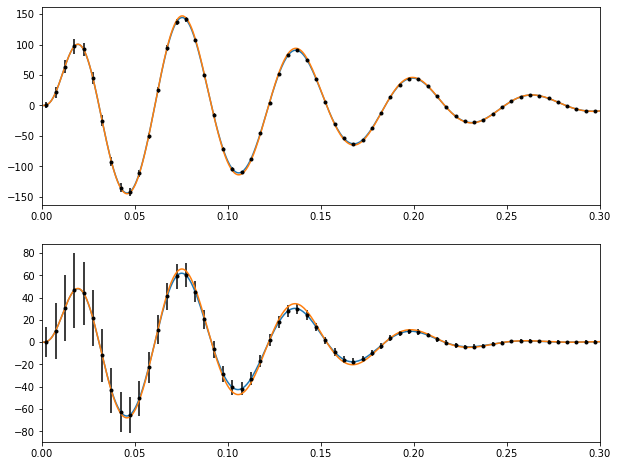

In [27]:
plt.figure(figsize=(10,8))

plt.subplot(2,1,1)

plt.plot(klin, klin * p0_zel, 'C0')
plt.plot(klin, klin * p0_emp, 'C1')

plt.errorbar(kdats, np.interp(kdats, klin, klin * p0_zel), fmt='.', yerr=kdats*err0/5, c='k')

plt.xlim(0,0.3)

plt.subplot(2,1,2)

plt.plot(klin, klin * p2_zel, 'C0')
plt.plot(klin, klin * p2_emp, 'C1')

plt.errorbar(kdats, np.interp(kdats, klin, klin * p2_zel), fmt='.', yerr=kdats*err2/5, c='k')


plt.xlim(0,0.3)

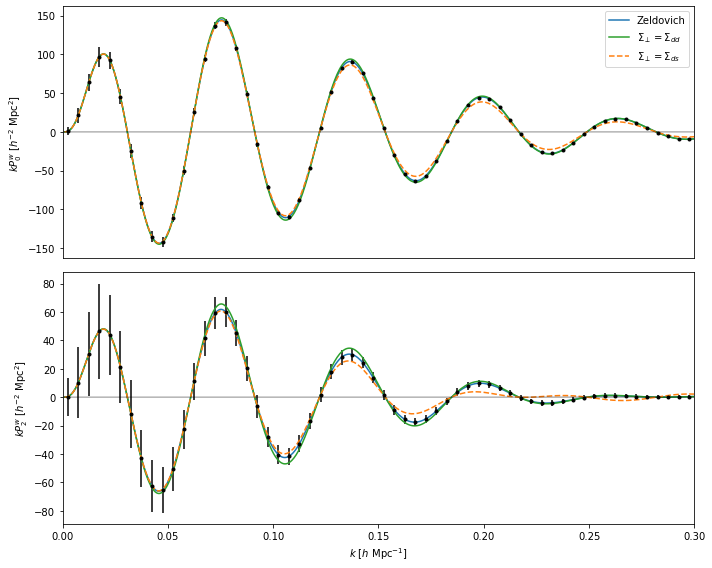

In [28]:
plt.figure(figsize=(10,8))

plt.subplot(2,1,1)

plt.plot(klin, klin * p0_zel, 'C0', label='Zeldovich')
plt.plot(klin, klin * p0_emp, 'C2', label=r'$\Sigma_\perp = \Sigma_{dd}$')
plt.plot(klin, klin * p0_emp2, 'C1--', label=r'$\Sigma_\perp = \Sigma_{ds}$')

plt.errorbar(kdats, np.interp(kdats, klin, klin * p0_zel), fmt='.', yerr=kdats*err0/5, c='k')

plt.plot(klin, 0*klin, 'k', alpha=0.3)


plt.xticks([])
plt.xlim(0,0.3)

plt.ylabel(r'$k P^w_0$ [$h^{-2}$ Mpc$^2$]')

plt.legend()

plt.subplot(2,1,2)

plt.plot(klin, klin * p2_zel, 'C0')
plt.plot(klin, klin * p2_emp, 'C2')
plt.plot(klin, klin * p2_emp2, 'C1--')

plt.errorbar(kdats, np.interp(kdats, klin, klin * p2_zel), fmt='.', yerr=kdats*err2/5, c='k')

plt.plot(klin, 0*klin, 'k', alpha=0.3)



plt.xlim(0,0.3)

plt.ylabel(r'$k P^w_2$ [$h^{-2}$ Mpc$^2$]')
plt.xlabel(r'$k$ [$h$ Mpc$^{-1}$]')

plt.tight_layout()